# Predicting "Opioid Prescribers" 

**The overarching aim of this project is to predict which Doctors will prescribe higher than average amounts of opiods and, thus, be termed an "Opiod Prescriber."


**The goals are to:**
- Wrangle the data
- Predict opiod prescribers in the USA.
- Find which predictors are most significant
- Analyze and compare possible trends in opiod prescription within subfields in the USA and New Mexico, USA

**Dataset:**
The open source data for this project was acquired (and can be downloaded) from: https://www.kaggle.com/apryor6/us-opiate-prescriptions
The data is made up of three .csv files "opiods.csv", "overdoses.csv", and "prescriber-info.csv"

This dataset contains summaries of prescription records for 250 common opioid and non-opioid drugs written by 25,000 unique licensed medical professionals in 2014 in the United States for citizens covered under Class D Medicare as well as some metadata about the doctors themselves. This is a small subset of data that was sourced from cms.gov. The full dataset contains almost 24 million prescription instances in long format. Dr. Alan ("AJ") Pryor (who posted this dataset on Kaggle) has cleaned and compiled this data here in a format with 1 row per prescriber and limited the approximately 1 million total unique prescribers down to 25,000 to keep it manageable. For instructions on getting the full data, plese refer to the instructions listed by Dr. Pryor in the kaggle link above.

## **PART 1:**

## **Setup, Wrangling, and EDA 

### A. Import packages and get the data

In [1]:
#for data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import re

#for data visualizations
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
%matplotlib inline
import pylab

#for machine learning
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
print ('Libraries Loaded')

Libraries Loaded


In [2]:
prescriber = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/prescriber-info.csv')
opioids = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/opioids.csv')
overdose = pd.read_csv('/Users/rmtaylor/ML/Projects/Opioids/overdoses.csv')
print ('Data Loaded')

Data Loaded


### B. First look at the PRESCRIBER DATASET first

#### 1. Prescriber Dataset

In [3]:
prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [4]:
prescriber.columns

Index(['NPI', 'Gender', 'State', 'Credentials', 'Specialty', 'ABILIFY',
       'ACETAMINOPHEN.CODEINE', 'ACYCLOVIR', 'ADVAIR.DISKUS', 'AGGRENOX',
       ...
       'VERAPAMIL.ER', 'VESICARE', 'VOLTAREN', 'VYTORIN', 'WARFARIN.SODIUM',
       'XARELTO', 'ZETIA', 'ZIPRASIDONE.HCL', 'ZOLPIDEM.TARTRATE',
       'Opioid.Prescriber'],
      dtype='object', length=256)

In [5]:
prescriber.shape

(25000, 256)

We can see that that:
- There is a prescriber #, gender, state, credentials, and specialty followed by a list of drugs prescribed

### **C. EDA and Wrangling of non-drug features**
**Let's see what the different specialties in the Specialty feature are...**

In [6]:
prescriber["Specialty"].value_counts().sort_values(ascending = False)

Internal Medicine                                                 3194
Family Practice                                                   2975
Dentist                                                           2800
Nurse Practitioner                                                2512
Physician Assistant                                               1839
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              615
Orthopedic Surgery                                                 575
Optometry                                                          571
Student in an Organized Health Care Education/Training Program     547
Ophthalmology                                                      519
General Surgery                                                    487
Gastro

**We can see that there are 109 different specialties listed (length)**

In [7]:
len(prescriber["Specialty"].value_counts().sort_values(ascending = False))

109

**Let's look at the credentials feature now...**

In [1]:
#uncomment to see list
#prescriber["Credentials"].value_counts().sort_values(ascending = False)

##### From looking at the credentials, we see that:
- We have a mess as far as formating

- We will need to clean the credentials by:

    **-We will need to use Regex to make all of the same credentials have the same format (i.e. no periods or spaces)**
    - removing periods, commas, and dashes in all credentials
    - for all listings with multiple degrees in a single row, we will create new features called "Medical", "Doctorate", "Master", "Bachelor", "Associate", and "License" 
    - We will then look at the credential list again to make sure we have cleaned up all info.

**Let's start by removing periods and then replacing commas with a space**

In [9]:
prescriber = prescriber.replace({'Credentials': r'\.'}, {'Credentials': ''}, regex=True)
prescriber = prescriber.replace({'Credentials': r','}, {'Credentials': ' '}, regex=True)

In [2]:
#uncomment to see list
#prescriber["Credentials"].value_counts().sort_values(ascending = False)

**Let's take care of a few special cases now before we split the column...**

**I'm formating the credentials so that I can split the column**

In [11]:
prescriber = prescriber.replace({'Credentials': r'M D'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D O'}, {'Credentials': 'DO'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'O D'}, {'Credentials': 'OD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D S'}, {'Credentials': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'P A'}, {'Credentials': 'PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD>'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D S M D'}, {'Credentials': 'DDS MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D D O M S'}, {'Credentials': 'DDO MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'C FNP'}, {'Credentials': 'NP'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D P C'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D MPH'}, {'Credentials': 'MD MPH'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD ; MB BS'}, {'Credentials': 'MD MB MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'AT C CSCS'}, {'Credentials': 'ATC CSCS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MS;BS'}, {'Credentials': 'MS BS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D O P C'}, {'Credentials': 'DO'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'ACNP/FNP'}, {'Credentials': 'NP'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'M D F A A D'}, {'Credentials': 'MD FAAD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD/'}, {'Credentials': 'MD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'PH D PA-C'}, {'Credentials': 'PA PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r' (DMD)'}, {'Credentials': 'DMD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'PH D MD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'DMD M S'}, {'Credentials': 'DMD MS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'D P M'}, {'Credentials': 'DPM'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MD/PHD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'DD S'}, {'Credentials': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDPHD'}, {'Credentials': 'MD PHD'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDPA'}, {'Credentials': 'MD PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'R PA-C'}, {'Credentials': 'PA'}, regex=True)
prescriber = prescriber.replace({'Credentials': r'MDFACP'}, {'Credentials': 'MD FACP'}, regex=True)
print ('Changes Complete')

Changes Complete


In [12]:
prescriber["Credentials"].value_counts().sort_values(ascending = False)

MD                     14113
DDS                     1953
DO                      1469
PA-C                     923
DMD                      731
PA                       616
NP                       582
OD                       536
DPM                      356
FNP                      289
ARNP                     273
CRNP                     157
APRN                     139
PAC                      104
CNP                       92
MD  PHD                   87
NP-C                      85
FNP-C                     73
APN                       70
FNP-BC                    56
ANP                       47
MD  MPH                   43
RPA-C                     41
MD PHD                    33
PHARMD                    31
CFNP                      29
MD                        28
MBBS                      26
NURSE PRACTITIONER        23
APNP                      21
                       ...  
PMHCNS-BC                  1
NP-F                       1
MS  RN  FNP-C              1
ARNP RN BSN MS

**Now I'll split the column...**

In [13]:
# new data frame with split value columns 
new = prescriber["Credentials"].str.split(" ", n = 1, expand = True) 
  
# making seperate Cred1 (1st credential) column from new data frame 
prescriber["Cred1"]= new[0] 
  
# making seperate Cred2 column from new data frame 
prescriber["Cred2"]= new[1] 

In [14]:
pd.set_option('display.max_rows', 800)
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD                14480
DDS                2071
DO                 1492
PA-C                941
DMD                 777
PA                  639
NP                  592
OD                  547
DPM                 362
FNP                 303
ARNP                290
APRN                180
CRNP                161
PAC                 104
RN                  100
CNP                  95
NP-C                 86
APN                  81
FNP-C                74
FNP-BC               62
MSN                  61
ANP                  49
RPA-C                42
MBBS                 34
DNP                  33
PHARMD               32
MS                   31
CFNP                 29
NURSE                25
PHYSICIAN            23
CNM                  21
APNP                 21
ANP-BC               21
CNS                  15
APRN-BC              14
ND                   13
RPAC                 13
PHD                  13
PMHNP                12
ACNP-BC              12
ACNP                 12
MPAS            

In [15]:
len(prescriber["Cred1"].value_counts().sort_values(ascending = False))

205

**We have 206 different credentials or formats for credentials**

Let's now combine degrees that are the same and also fill in nan values with "unknown"

In [16]:
# Nurse Practioner records:
for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.NP+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.NP.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'NP.'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.RN+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'RN+'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.PN+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PN+'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'NURSE'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'.CNS+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.CNS.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS.+'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNS.'}, {'Cred1': 'NP'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'ANRP'}, {'Cred1': 'NP'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'CNFP'}, {'Cred1': 'NP'}, regex=True)
    
    
    
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [17]:
# uncomment to check it worked
# prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [18]:
# MD Records:

for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.MD+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.MD.+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD.+'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MD.'}, {'Cred1': 'MD'}, regex=True)
    
    prescriber = prescriber.replace({'Cred1': r'MBBS'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PHYSICIAN'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MBBCH'}, {'Cred1': 'MD'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'MB'}, {'Cred1': 'MD'}, regex=True)
    
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [19]:
# uncomment to check it worked
# prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [20]:
# PA Records:

for x in range (0, 6):
    prescriber = prescriber.replace({'Cred1': r'.PA+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'.PA.+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA.+'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA'}, {'Cred1': 'PA'}, regex=True)
    prescriber = prescriber.replace({'Cred1': r'PA.'}, {'Cred1': 'PA'}, regex=True)
    print (x, 'Changes Complete')

0 Changes Complete
1 Changes Complete
2 Changes Complete
3 Changes Complete
4 Changes Complete
5 Changes Complete


In [21]:
# uncomment to check it worked
#prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [22]:
# DDS (Dentist) Records:
prescriber = prescriber.replace({'Cred1': r'DMD'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DDS'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DDS.+'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DENTIST'}, {'Cred1': 'DDS'}, regex=True)


# OD (Optometrist) Records:
prescriber = prescriber.replace({'Cred1': r'OPHTHALMOLGIST'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OPTOMETRIST'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FAAO'}, {'Cred1': 'OD'}, regex=True)

# fill records where the physician name was incorrectly entered in the credentials with "unknown"
prescriber = prescriber.replace({'Cred1': r'ANNA'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GREG'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'HERSCHEL'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'EIN-'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BRIAN'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FLORA'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GERALD'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'JAMES'}, {'Cred1': 'Unknown'}, regex=True)

# Fix DPM error
prescriber = prescriber.replace({'Cred1': r'DPM`'}, {'Cred1': 'DPM'}, regex=True)


print ('Changes Complete')

Changes Complete


In [23]:
# uncomment to check it worked
#prescriber["Cred1"].value_counts().sort_values(ascending = False)

**Now let's look at the Cred1 and Cred2 columns together so we can fix places where the terminal degree wasn't in the Cred1 column.**

In [24]:
# Uncomment each ONE AT A TIME to inspect and find rows where we need to add Cred 1
#prescriber[prescriber.Cred2 == 'PA']
#prescriber[prescriber.Cred2 == 'MD']
#prescriber[prescriber.Cred2 == 'NP']
#prescriber[prescriber.Cred2 == 'DDS']
#prescriber[prescriber.Cred2 == 'OD']

**From the last step, I see that I need to change a few items**

In [25]:
prescriber = prescriber.replace({'Cred1': r'PHP'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'FACEP'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^D$'}, {'Cred1': 'MD'}, regex=True)

prescriber = prescriber.replace({'Cred1': r'C-'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'ADULT'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DR'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSN'}, {'Cred1': 'NP'}, regex=True)

In [3]:
# uncomment to check it worked
#prescriber["Cred1"].value_counts().sort_values(ascending = False)

In [27]:
#I know used the below code (a few examples shown) to go through the results from the step above that had only a single record. 
#I did this to find out what was in the Cred2 column

#prescriber[prescriber.Cred1 == 'BA']
#prescriber[prescriber.Cred1 == 'PCS']
#prescriber[prescriber.Cred1 == 'MS']...

**By using the code in the cell above, I found several things to update in Cred1**

**I also looked at the results and decided to drop rows with credentials that had less than 32 records.**

In [28]:
#Making changes to Cred1 
prescriber = prescriber.replace({'Cred1': r'BA'}, {'Cred1': 'DO'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DNSC'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BSHS'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'ATC'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OO'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BSN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSSW'}, {'Cred1': 'LSW'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MSM'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'OTRL'}, {'Cred1': 'OT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DOCTOR'}, {'Cred1': 'OD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^M$'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MPT'}, {'Cred1': 'PT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'DPT'}, {'Cred1': 'PT'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'GENERAL'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'NFP'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MFTI'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BOARD'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PHC'}, {'Cred1': 'DDA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'AT'}, {'Cred1': 'Unknown'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PD'}, {'Cred1': 'DDS'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'PMH'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'RXN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^C$'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MN'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MHSA'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MMS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.drop(prescriber.index[6516])
prescriber = prescriber.replace({'Cred1': r'BS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber[prescriber.Cred1 != 'MED']
prescriber = prescriber[prescriber.Cred1 != 'DC']
prescriber = prescriber.replace({'Cred1': r'FAMILY'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'^N$'}, {'Cred1': 'NP'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MEDICAL'}, {'Cred1': 'MD'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'RPH'}, {'Cred1': 'DDA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'MHS'}, {'Cred1': 'PA'}, regex=True)
prescriber = prescriber.replace({'Cred1': r'BDS'}, {'Cred1': 'DDS'}, regex=True)

print ('Changes Complete')

Changes Complete


In [29]:
# uncomment to check it worked
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD         15380
NP          2486
DDS         2085
PA          1764
DO          1493
OD           552
DPM          363
MS            31
CNM           21
PHD           13
ND            13
Unknown        9
DDA            7
PT             4
PH             2
DP             1
PAC            1
MT             1
PSYD           1
OT             1
LSW            1
PCS            1
NPS            1
Name: Cred1, dtype: int64

In [30]:

# dropping rows that had a credential that appeared less than 32 times.
prescriber = prescriber[prescriber.Cred1 != 'DP']
prescriber = prescriber[prescriber.Cred1 != 'MT']
prescriber = prescriber[prescriber.Cred1 != 'LSW']
prescriber = prescriber[prescriber.Cred1 != 'NPS']
prescriber = prescriber[prescriber.Cred1 != 'PSYD']
prescriber = prescriber[prescriber.Cred1 != 'PCS']
prescriber = prescriber[prescriber.Cred1 != 'OT']
prescriber = prescriber[prescriber.Cred1 != 'PH']
prescriber = prescriber[prescriber.Cred1 != 'PT']
prescriber = prescriber[prescriber.Cred1 != 'DDA']
prescriber = prescriber[prescriber.Cred1 != 'Unknown']
prescriber = prescriber[prescriber.Cred1 != 'MS']
prescriber = prescriber[prescriber.Cred1 != 'CNM']
prescriber = prescriber[prescriber.Cred1 != 'ND']
prescriber = prescriber[prescriber.Cred1 != 'PHD']
prescriber = prescriber[prescriber.Cred1 != 'PAC']
print ('Changes Complete')

Changes Complete


**We can now look at our Cred1 column and see that our data looks MUCH more clean than what we started with!**

In [31]:
# uncomment to check it worked
prescriber["Cred1"].value_counts().sort_values(ascending = False)

MD     15380
NP      2486
DDS     2085
PA      1764
DO      1493
OD       552
DPM      363
Name: Cred1, dtype: int64

**Now, we'll need to drop the "NPI" column since this is a different/individual id number for each prescriber.**

**We will also drop the "Cred2" feature and change the name of "Cred1" to "Degree"**

**We will also change the name of Gender to DR_Gender to clarify that this is the gender of the PRESCRIBER and not the patient**

In [32]:
prescriber.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Cred1,Cred2
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,1,DDS,None
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,35,1,MD,None
2,1427182161,F,NY,MD,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,25,0,MD,None
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,1,MD,None
4,1679650949,M,NV,MD,Hematology/Oncology,0,0,0,0,0,...,0,0,17,28,0,0,0,1,MD,None


In [33]:
prescriber = prescriber.drop('NPI', axis=1)
prescriber = prescriber.drop('Cred2', axis=1)
prescriber = prescriber.drop('Credentials', axis=1)
prescriber.rename(columns={'Cred1': 'Degree', 'Gender': 'DR_Gender'}, inplace=True)
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,DDS
1,F,AL,General Surgery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,35,1,MD
2,F,NY,General Practice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,25,0,MD
3,M,AZ,Internal Medicine,0,43,0,0,0,21,0,...,0,0,0,0,0,0,0,0,1,MD
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,...,0,0,0,17,28,0,0,0,1,MD


**Great!!**

**Now we've done a lot. We have all of the non-drug columns cleaned up pretty well.**

### **D. EDA and Wrangling of drug features**

**Now, we need to address the drug columns.**

**Let's look at the drug columns now...**

In [34]:
prescriber.shape

(24886, 255)

In [35]:
pd.set_option('display.max_columns', 255)

In [36]:
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
#Uncomment if you'd like to see all the drug (column) names as a list

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(prescriber.head(1))

**All of the drug column names look good. We will normalize the values a little later for the alogorithms**

## **PART 2: EDA and Data Visualization**

### **Specialty Feature**

**Let's look at the 'Specialty' feature first...**

In [38]:
spec = prescriber["Specialty"].value_counts().sort_values(ascending = False)

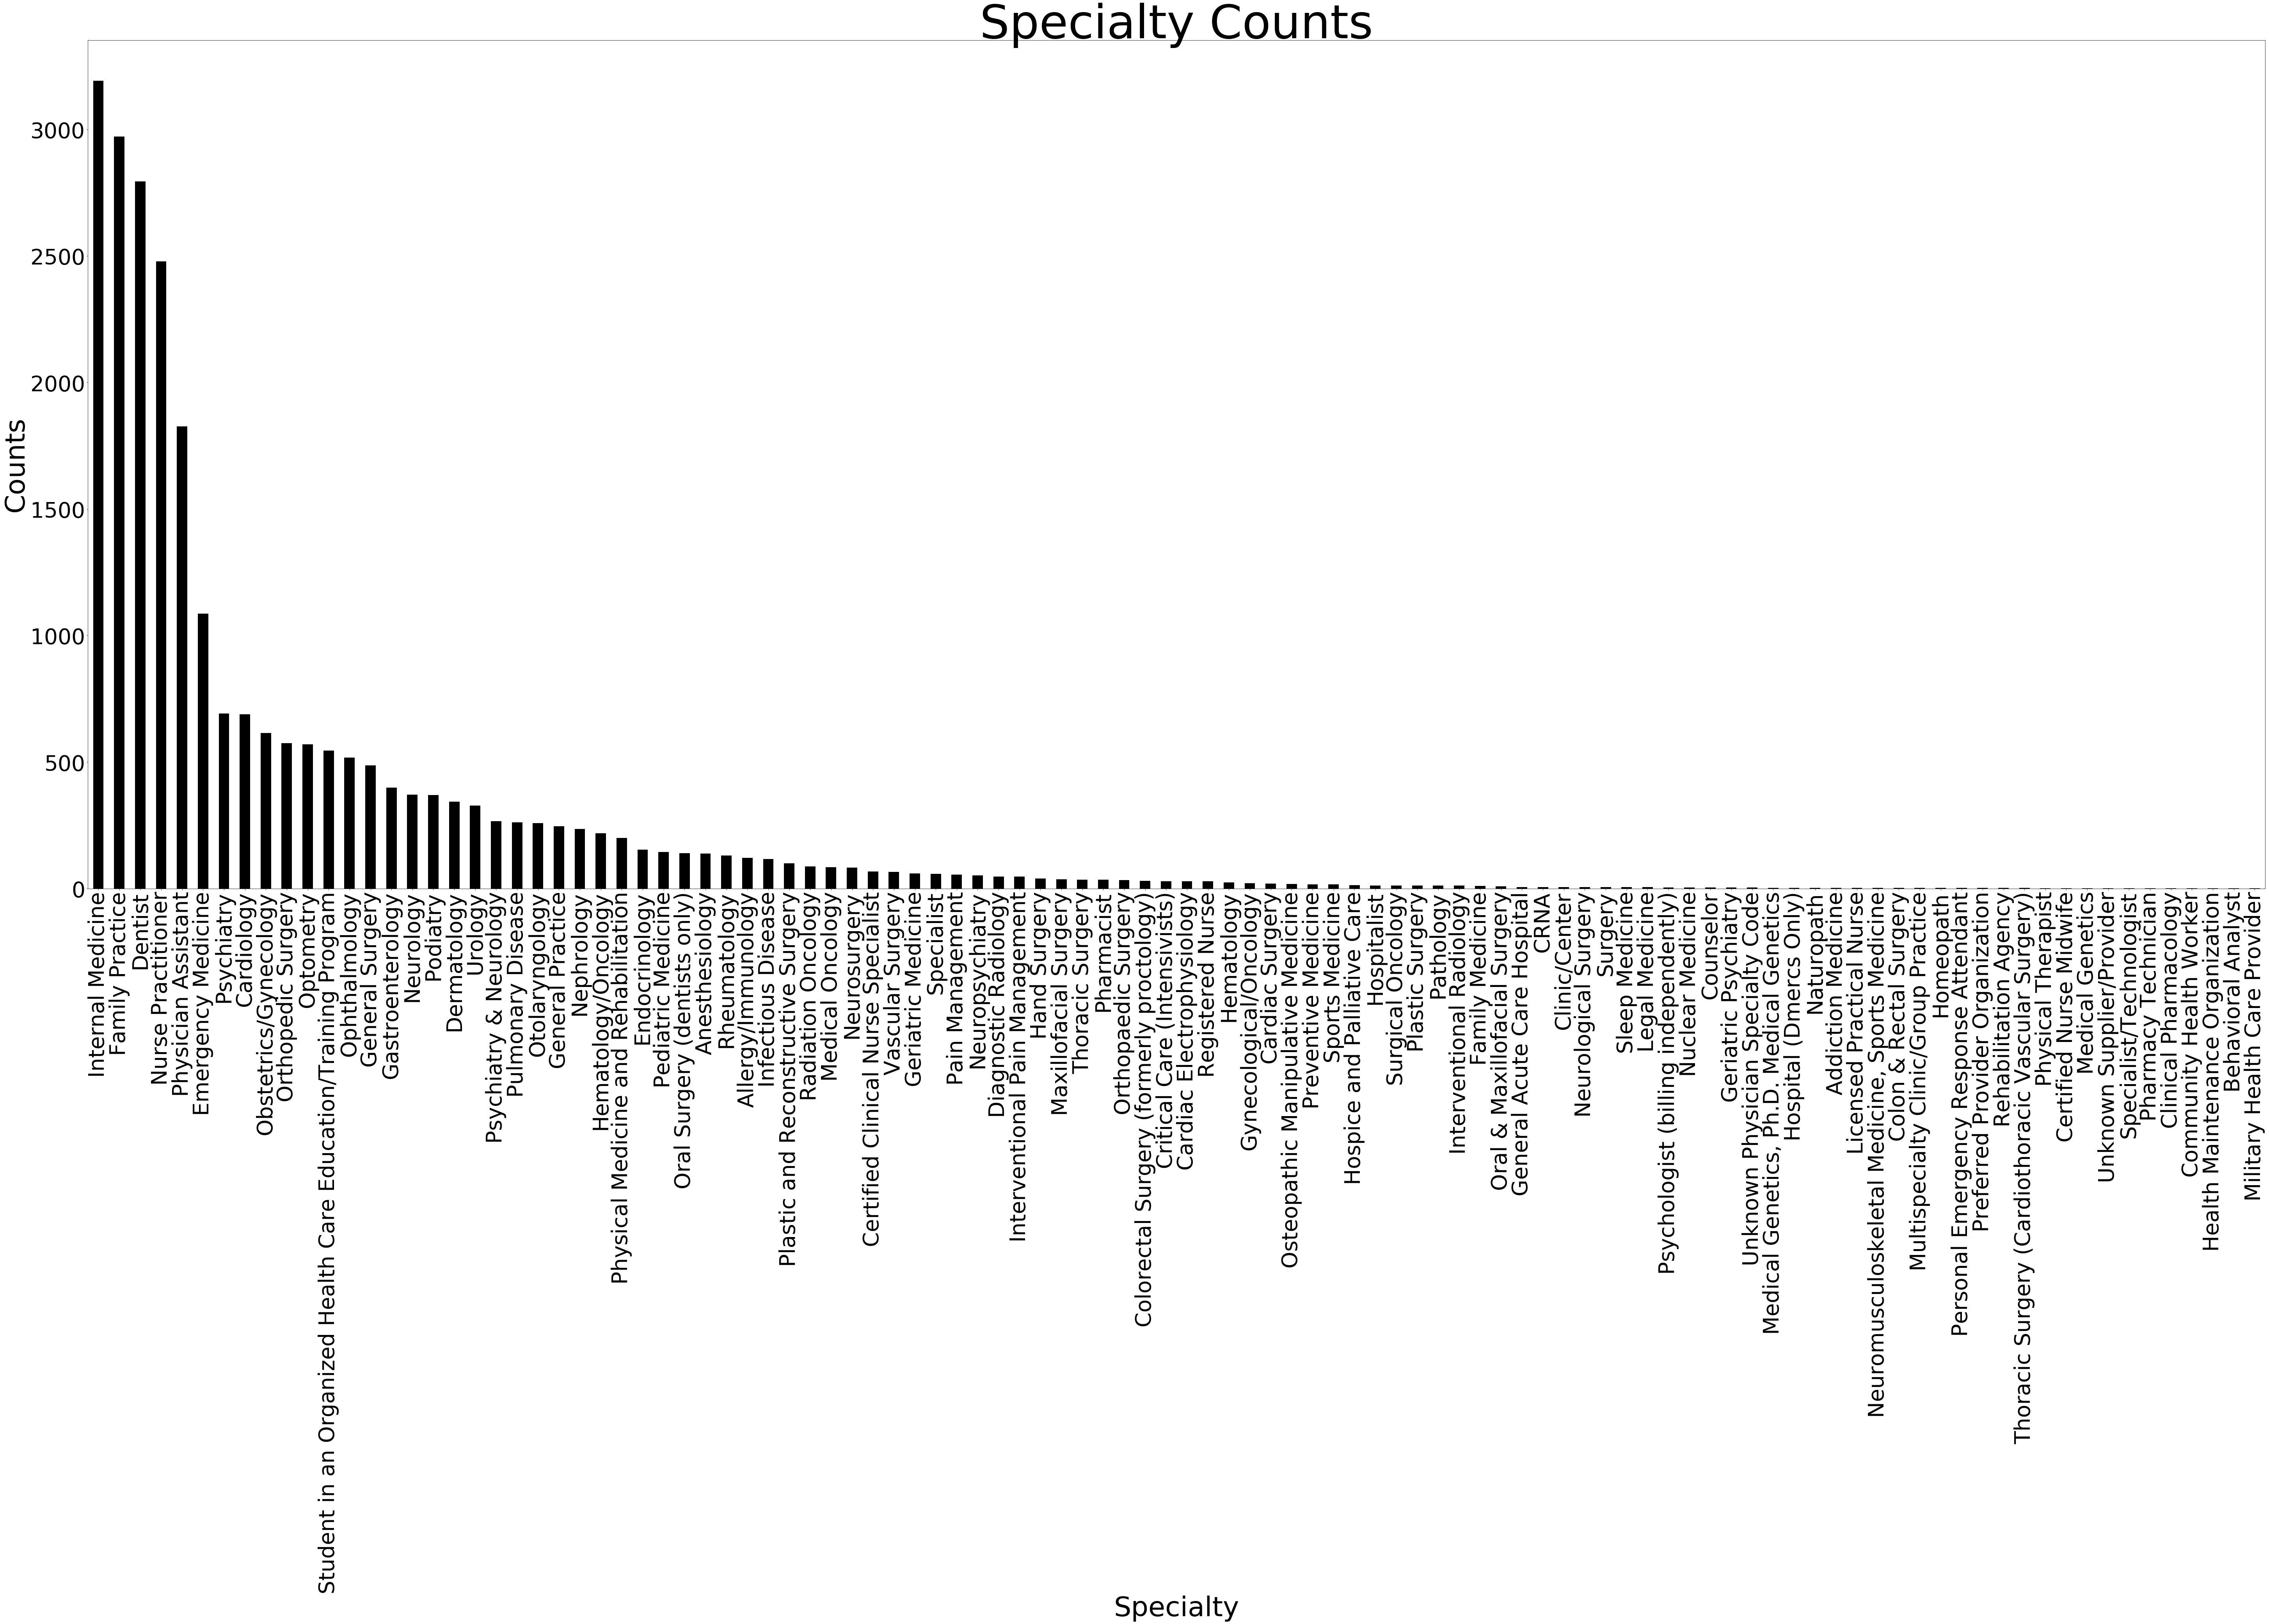

In [39]:
spec.plot(kind='bar', figsize = (100, 40), color='black')
plt.xlabel('Specialty', fontsize=70)
plt.xticks(rotation=90, fontsize=55)
plt.ylabel('Counts', fontsize=70)
plt.yticks(fontsize=55)
plt.title('Specialty Counts', fontsize=120)

#for the text box which includes the top 10 specialties by count
spec10 = str(spec[:10]) 
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=4)
#plt.text(15, 12, (spec10), fontsize=65, transform=ax.transAxes, bbox=props, ha='right')

plt.show()

**Let's look at the top 10 results**

In [40]:
spec[:10]

Internal Medicine        3193
Family Practice          2972
Dentist                  2795
Nurse Practitioner       2479
Physician Assistant      1826
Emergency Medicine       1087
Psychiatry                691
Cardiology                688
Obstetrics/Gynecology     614
Orthopedic Surgery        575
Name: Specialty, dtype: int64

### **Degree Feature**

**Let's look at the 'Degree' feature next...**

In [41]:
deg = prescriber["Degree"].value_counts().sort_values(ascending = False)
deg

MD     15380
NP      2486
DDS     2085
PA      1764
DO      1493
OD       552
DPM      363
Name: Degree, dtype: int64

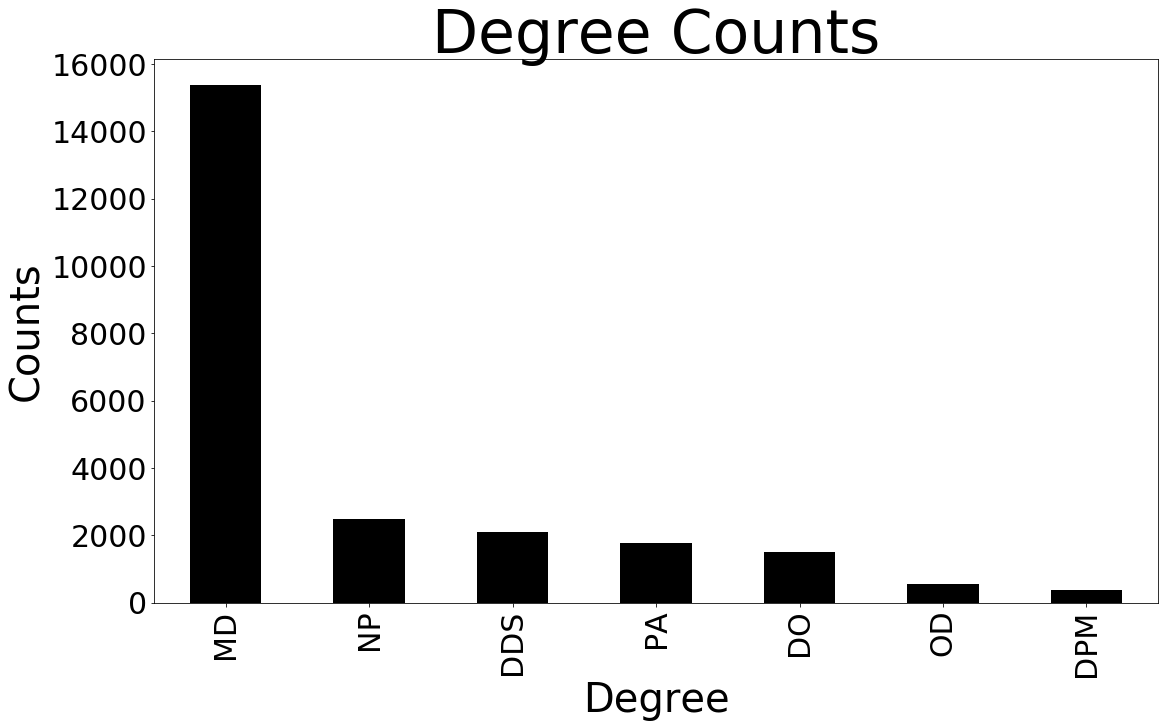

In [42]:
deg.plot(kind='bar', figsize = (18, 10), color='black')
plt.xticks(rotation=25)

plt.xlabel('Degree', fontsize=40)
plt.xticks(rotation=90, fontsize=30)
plt.ylabel('Counts', fontsize=40)
plt.yticks(fontsize=30)
plt.title('Degree Counts', fontsize=60)



#for the text box which includes the top 10 specialties by count\
text = str(deg)
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=4)
#plt.text(1.5, 1.5, (text), fontsize=15, transform=ax.transAxes, bbox=props, ha='center')


plt.show()

### **DR_Gender Feature**

**Let's look at the 'DR_Gender' feature next...**

In [43]:
gen = prescriber["DR_Gender"].value_counts().sort_values(ascending = False)

In [44]:
gen

M    15538
F     9348
Name: DR_Gender, dtype: int64

In [45]:
M=15538
F=9348
T = M + F
percentM = (M/T)*100
percentF = (F/T)*100
print ('There are', round(percentM, 1), '% male and', round(percentF, 1), '% female prescribers in the dataset')

There are 62.4 % male and 37.6 % female prescribers in the dataset


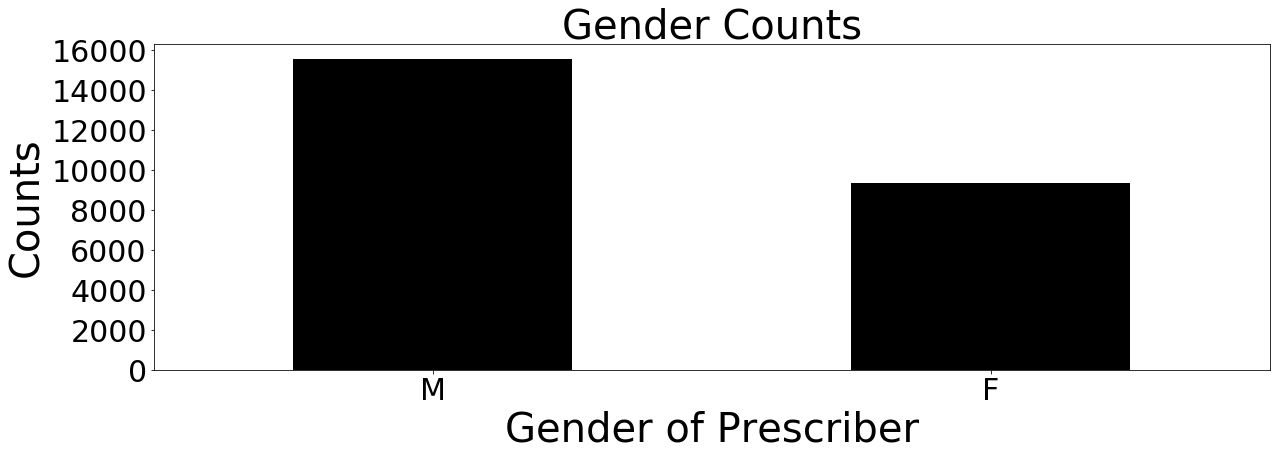

In [46]:
gen.plot(kind='bar', figsize = (20,6), color='black')

plt.xlabel('Gender of Prescriber', fontsize=40)
plt.xticks(rotation= 0, fontsize=30)
plt.ylabel('Counts', fontsize=40)
plt.yticks(fontsize=30)
plt.title('Gender Counts', fontsize=40)



#for the text box which includes the top 10 specialties by count\
text = str(gen)
text2 = (round(percentM, 1), '% male and', round(percentF, 1), '% female')
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=0.3)
#plt.text(3.2, 1.4, (text), fontsize=15, transform=ax.transAxes, bbox=props, ha='center')
#plt.text(3.19, 1.2, (text2), fontsize=15, transform=ax.transAxes, bbox=props, ha='center')



plt.show()

### **State Feature**

**Let's look at the 'State' feature next...**

In [47]:
sta = prescriber["State"].value_counts().sort_values(ascending = False)

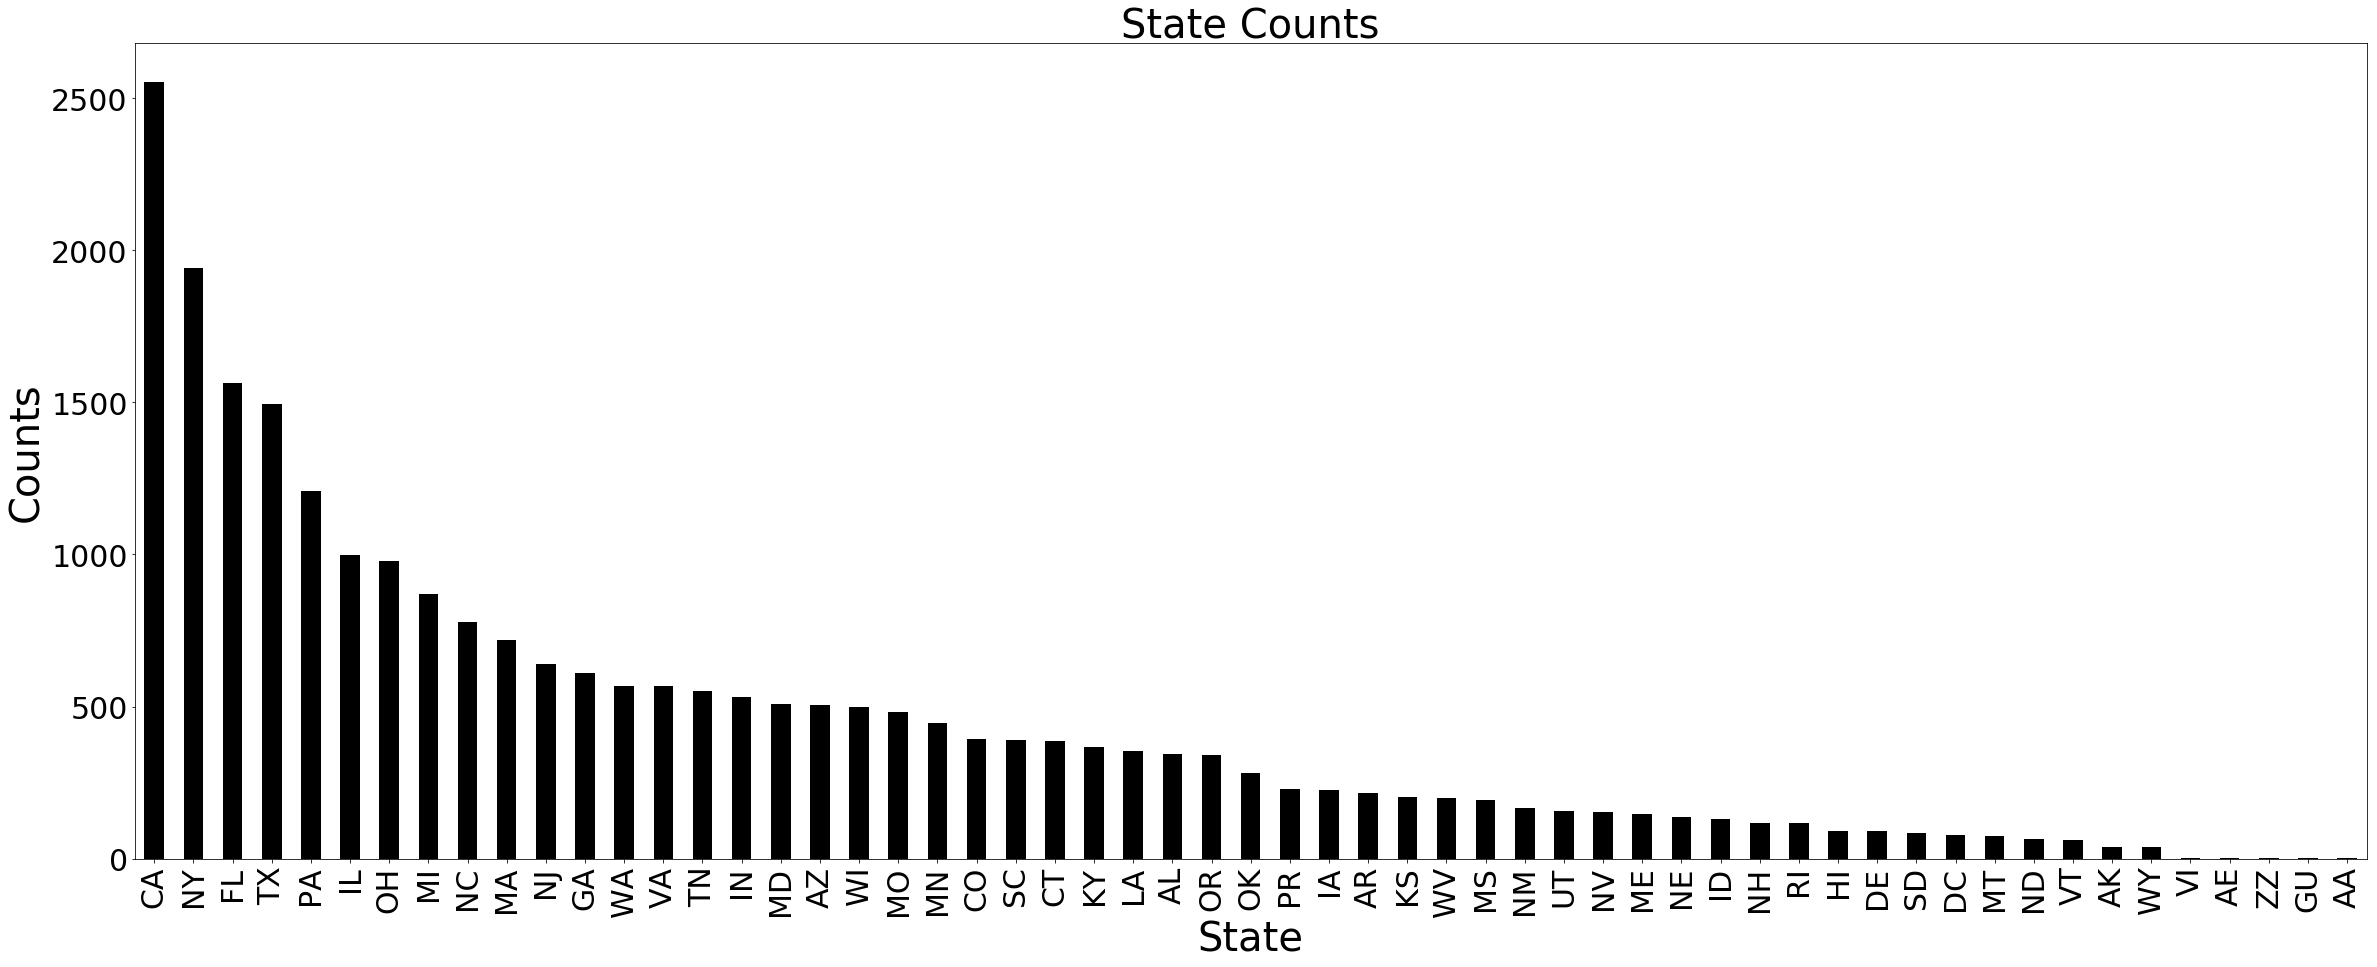

In [48]:
sta.plot(kind='bar', figsize = (40,15), color='black')

plt.xlabel('State', fontsize=40)
plt.xticks(rotation= 90, fontsize=30)
plt.ylabel('Counts', fontsize=40)
plt.yticks(fontsize=30)
plt.title('State Counts', fontsize=40)

plt.show()

In [49]:
len(sta)

57

In [50]:
#Uncomment to see full list of states
#sta

**We can see that there are a few errors in the states**

**We will drop rows from the prescriber dataframe that have incorrect state listings**

In [51]:
prescriber = prescriber[prescriber.State != 'VI']
prescriber = prescriber[prescriber.State != 'AE']
prescriber = prescriber[prescriber.State != 'ZZ']
prescriber = prescriber[prescriber.State != 'GU']
prescriber = prescriber[prescriber.State != 'AA']
print ('Changes Complete')

Changes Complete


**Now let's look again at the state data...**

In [52]:
sta = prescriber["State"].value_counts().sort_values(ascending = False)
print ('The top 10 results are\n', sta[0:10])

The top 10 results are
 CA    2553
NY    1941
FL    1563
TX    1494
PA    1208
IL     997
OH     980
MI     870
NC     777
MA     720
Name: State, dtype: int64


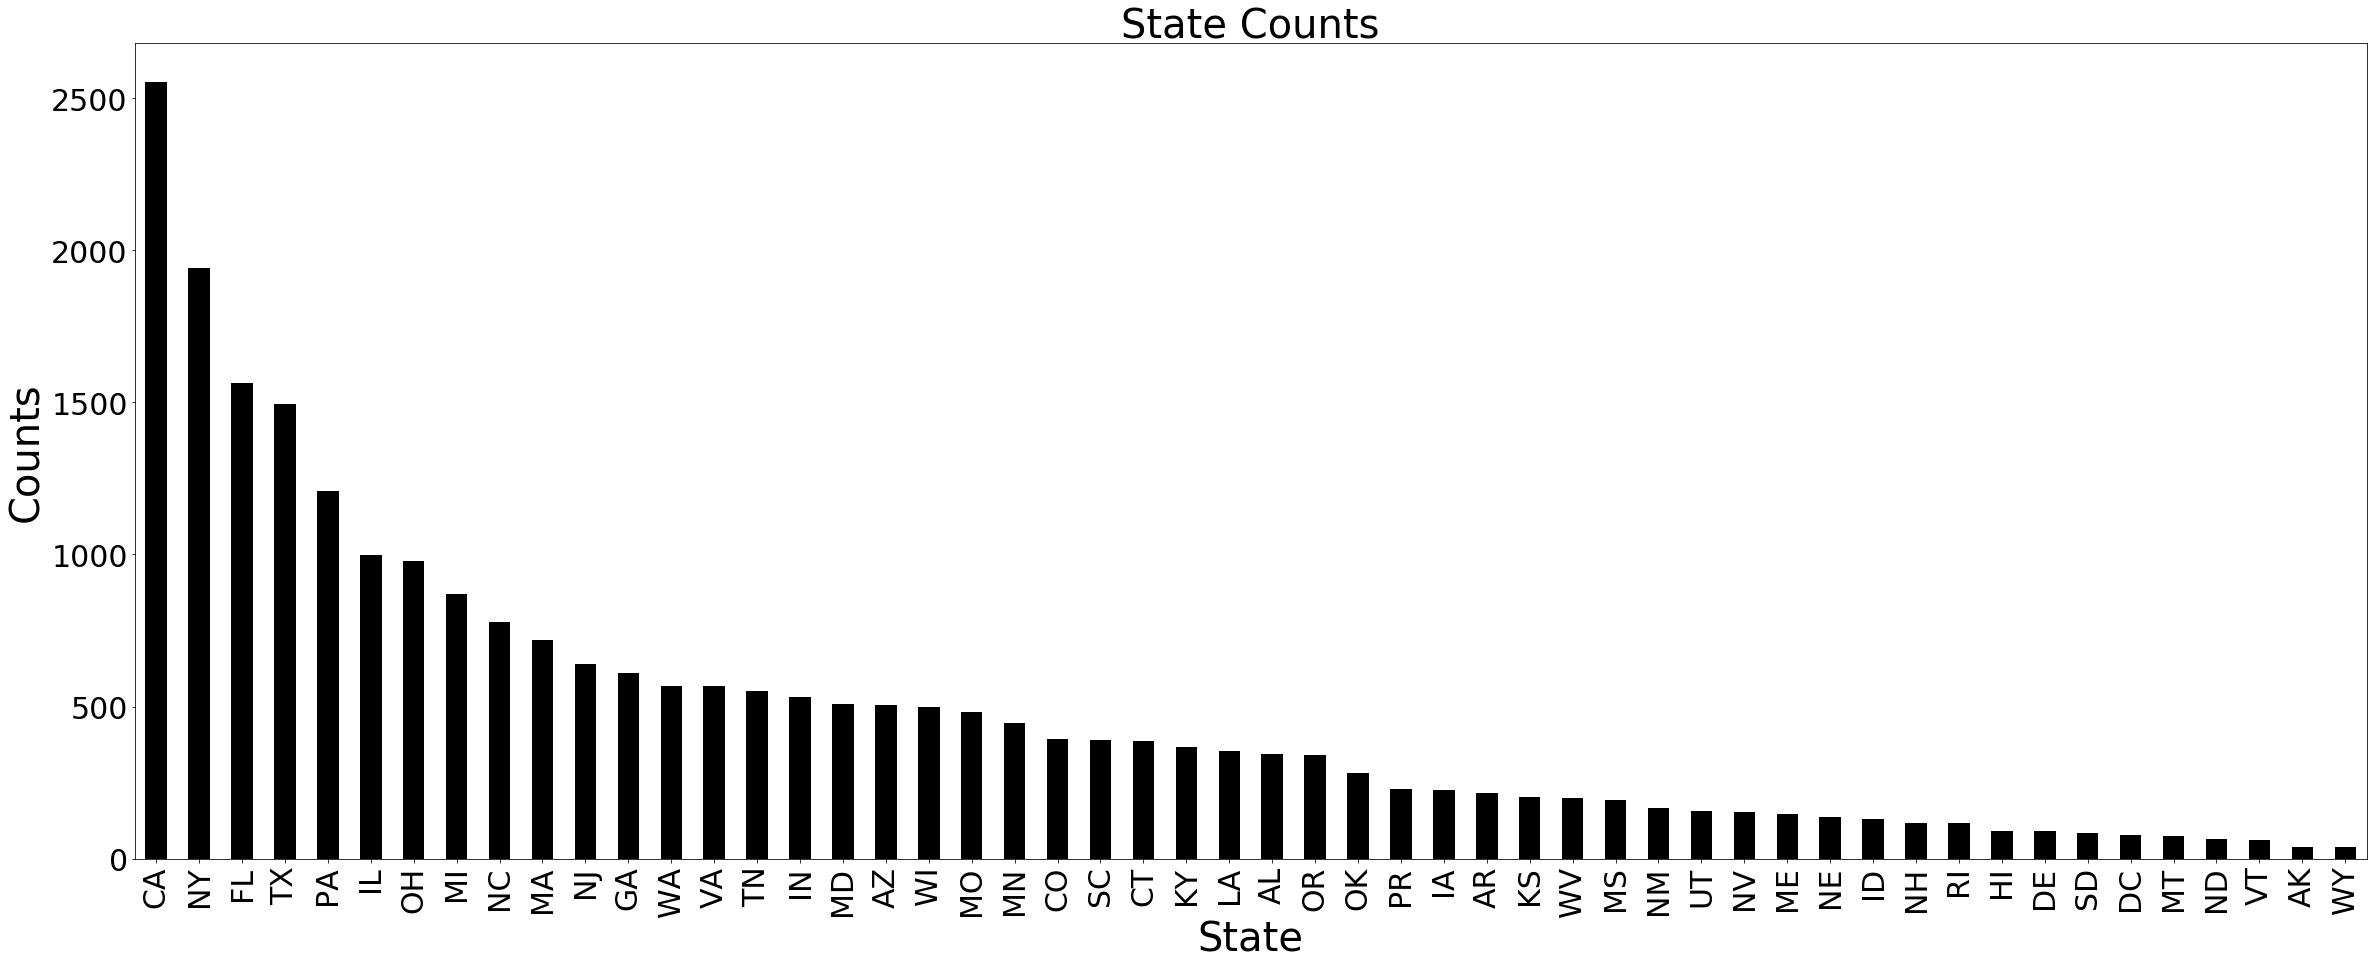

In [53]:
sta.plot(kind='bar', figsize = (40,15), color='black')

plt.xlabel('State', fontsize=40)
plt.xticks(rotation= 90, fontsize=30)
plt.ylabel('Counts', fontsize=40)
plt.yticks(fontsize=30)
plt.title('State Counts', fontsize=40)

#for the text box which includes the top 10 specialties by count\
text = str(sta[0:10])
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=3)
#plt.text(3.7, 1.7, (text), fontsize=30, transform=ax.transAxes, bbox=props, ha='center')

plt.show()

In [54]:
#Uncomment to see full list of states
#sta
sta.shape[0]

52

**Great!**
**Now we've visualized and cleaned up the state feature and are left with data for 52 states, which is what we want.**

### **Target Variable: "Opioid.Prescriber"**

**Let's look at our target variable now, which is the Opioid.Prescriber feature...**

In [55]:
op = prescriber["Opioid.Prescriber"].value_counts().sort_values(ascending = False)
op

1    14639
0    10237
Name: Opioid.Prescriber, dtype: int64

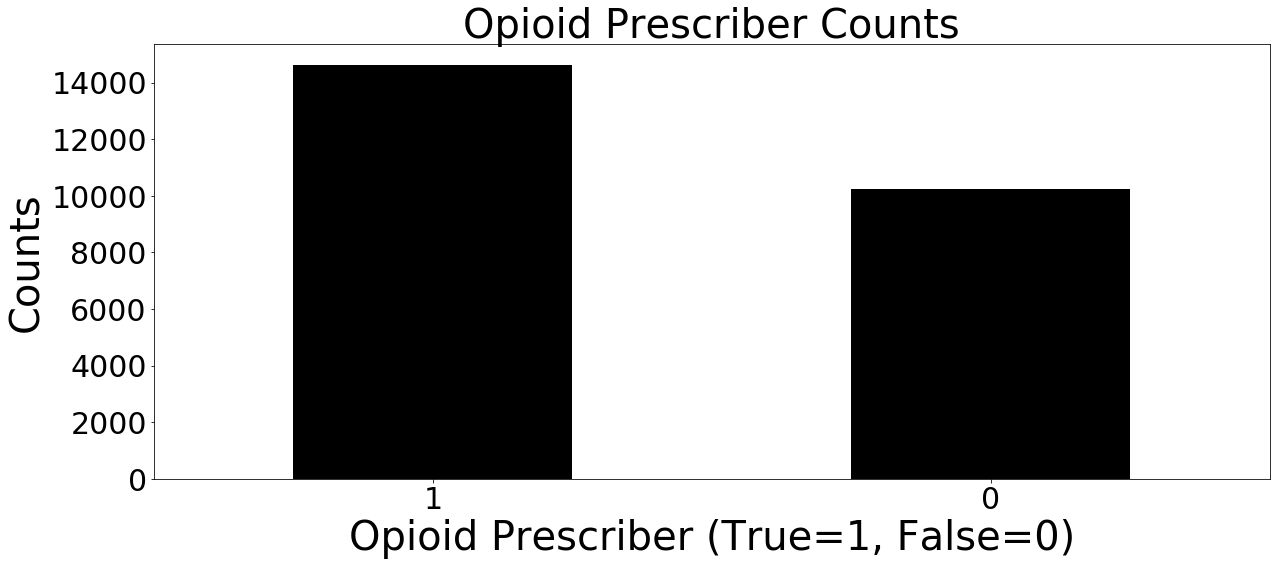

In [56]:
op.plot(kind='bar', figsize = (20,8), color='black')

plt.xlabel('Opioid Prescriber (True=1, False=0)', fontsize=40)
plt.xticks(rotation= 0, fontsize=30)
plt.ylabel('Counts', fontsize=40)
plt.yticks(fontsize=30)
plt.title('Opioid Prescriber Counts', fontsize=40)

#for the text box which includes the top 10 specialties by count\
text = str(op)
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=0.3)
#plt.text(3, 1.8, (text), fontsize=15, transform=ax.transAxes, bbox=props, ha='center')

plt.show()

**We see that we have a fairly even split with 14,639 considered Opioid Prescribers and 10,237 that are not considered Opioid Prescribers**

## **PART 3: EDA With Correlations**

**Let's look for any correlations...**

In [57]:
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,M,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,

In [58]:
# Correlation between Specialty and Opioid.Prescriber
spec = prescriber[["Specialty", "Opioid.Prescriber"]].groupby(["Specialty"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
spec

,Specialty,Opioid.Prescriber
11,Clinical Pharmacology,1.000000
32,Health Maintenance Organization,1.000000
101,Unknown Supplier/Provider,1.000000
100,Unknown Physician Specialty Code,1.000000
81,Preferred Provider Organization,1.000000
97,Surgical Oncology,1.000000
14,Community Health Worker,1.000000
31,Hand Surgery,1.000000
66,Orthopedic Surgery,0.986087
69,Pain Management,0.963636


In [59]:
# Correlation between Degree and Opioid.Prescriber
degree_corr = prescriber[["Degree", "Opioid.Prescriber"]].groupby(["Degree"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
degree_corr

,Degree,Opioid.Prescriber
1,DO,0.772271
6,PA,0.687465
3,MD,0.619048
2,DPM,0.606061
4,NP,0.528158
0,DDS,0.390595
5,OD,0.007246


<function matplotlib.pyplot.show(*args, **kw)>

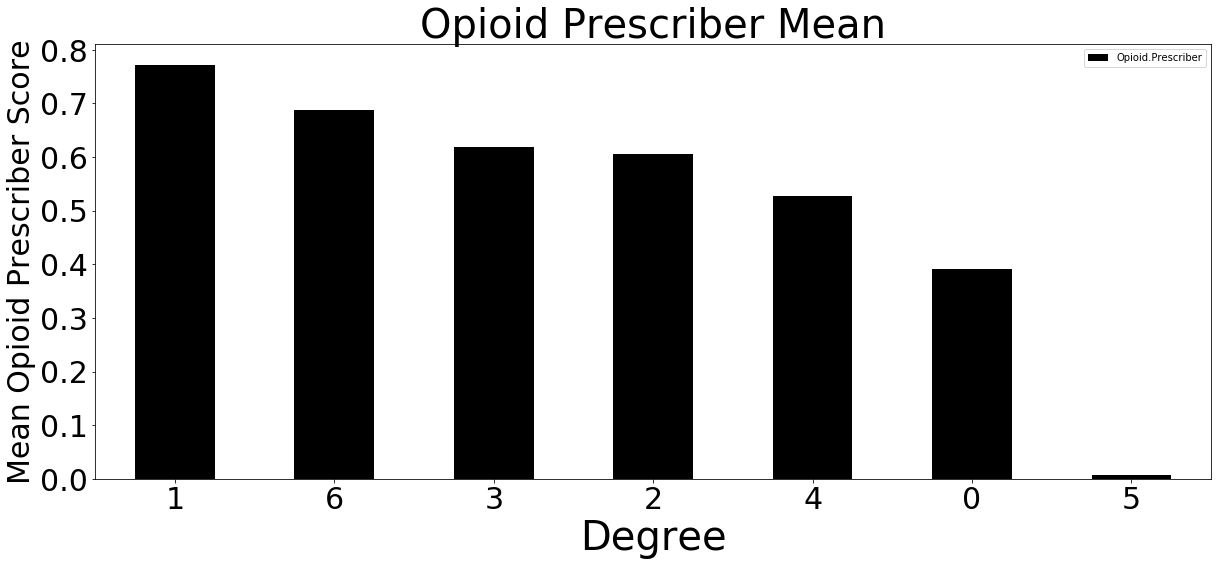

In [60]:
degree_corr.plot(kind='bar', figsize = (20,8), color='black')

plt.xlabel('Degree', fontsize=40)
plt.xticks( rotation=0, fontsize=30)
plt.ylabel('Mean Opioid Prescriber Score', fontsize=30)
plt.yticks(fontsize=30)
plt.title('Opioid Prescriber Mean', fontsize=40)

#for the text box which includes the top 10 specialties by count\
text = str(degree_corr)
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=0.3)
#plt.text(3, 1.4, (text), fontsize=15, transform = ax.transAxes, bbox=props, ha='center')

plt.show

**The Degree correlations are interesting.**
**They could suggest that individuals with a DO or PA could need more training or oversight for opioid prescribing, to get the prescription levels down to equal that of MDs perhaps??**

In [61]:
# Correlation between DR_Gender and Opioid.Prescriber
gen_corr = prescriber[["DR_Gender", "Opioid.Prescriber"]].groupby(["DR_Gender"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
gen_corr

,DR_Gender,Opioid.Prescriber
1,M,0.613701
0,F,0.546554


In [62]:
# Correlation between state and Opioid.Prescriber
sta_corr = prescriber[["State", "Opioid.Prescriber"]].groupby(["State"], as_index=False).mean().sort_values(by="Opioid.Prescriber", ascending=False)
sta_corr

,State,Opioid.Prescriber
2,AR,0.736111
36,OK,0.729537
26,MT,0.723684
1,AL,0.708455
33,NV,0.701299
0,AK,0.692308
25,MS,0.671875
13,ID,0.666667
45,UT,0.664557
41,SC,0.661538


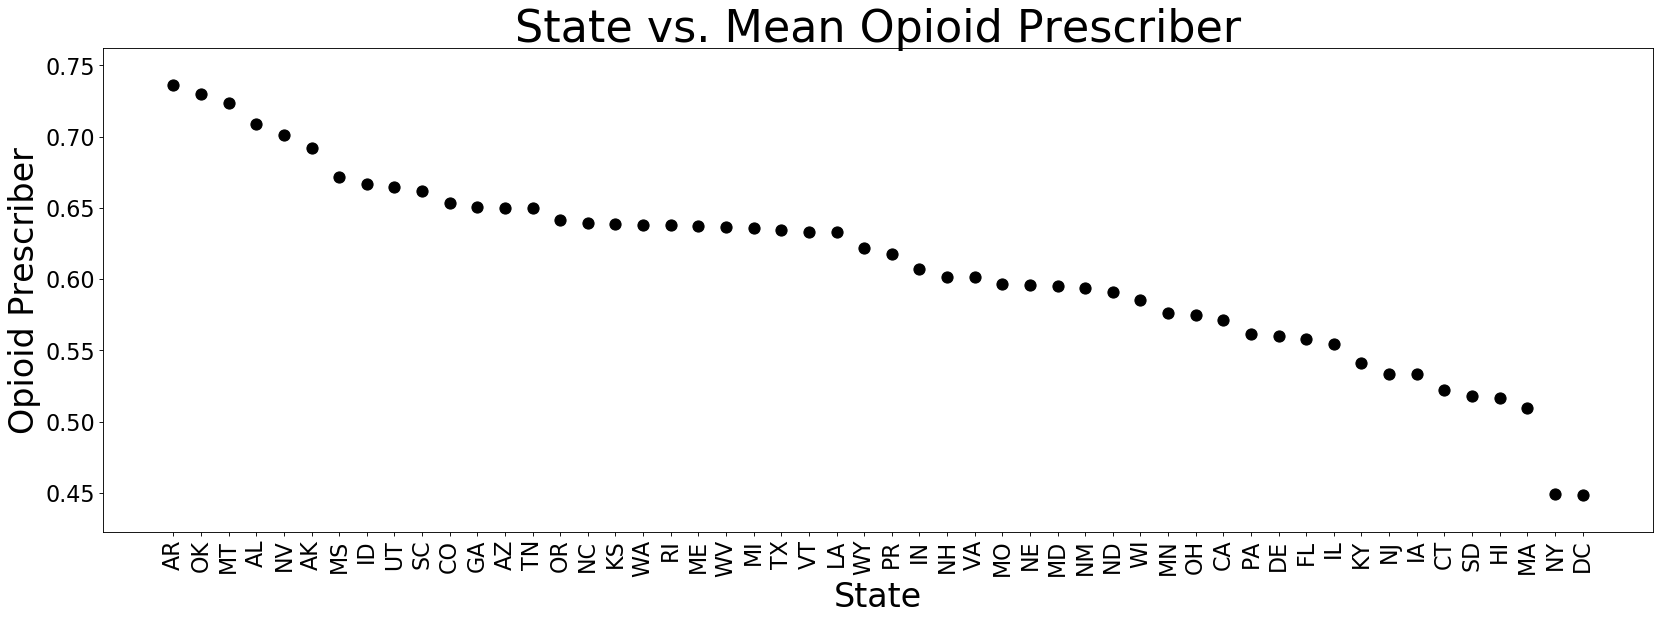

In [63]:

plt.figure(figsize=(25, 8), dpi=80)
plt.scatter(sta_corr.State, sta_corr['Opioid.Prescriber'], s=100, alpha=1, color = 'black')
plt.xticks(rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("State", fontsize = 30)
plt.ylabel("Opioid Prescriber", fontsize = 30)
plt.title("State vs. Mean Opioid Prescriber", fontsize = 40)

#for the text box which includes the top 10 specialties by count\
text = str(sta_corr[:10])
props = dict(boxstyle='round', facecolor='wheat', edgecolor='black', alpha=0.5, pad=0.2)
#plt.text(.68, .38, (text), fontsize=20, transform=ax.transAxes, bbox=props, ha='center')


plt.show()

In [64]:
print ('The top 10 results are\n', sta_corr[:10])

The top 10 results are
    State  Opioid.Prescriber
2     AR           0.736111
36    OK           0.729537
26    MT           0.723684
1     AL           0.708455
33    NV           0.701299
0     AK           0.692308
25    MS           0.671875
13    ID           0.666667
45    UT           0.664557
41    SC           0.661538


## **PART 4: Pre-processing**

## Convert Categorical features to numerical values

Lets look at gender:

In [65]:
prescriber.groupby(['DR_Gender'])['Opioid.Prescriber'].value_counts(normalize=True)

DR_Gender  Opioid.Prescriber
F          1                    0.546554
           0                    0.453446
M          1                    0.613701
           0                    0.386299
Name: Opioid.Prescriber, dtype: float64

54.7 % of female are considered opioid prescribers while 61.4 % of males are considered opioid prescribers


Lets convert male to 0 and female to 1:


In [66]:
prescriber['DR_Gender'].replace(to_replace=['M','F'], value=[0,1],inplace=True)
prescriber.head()

,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,Degree
0,0,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,

**Let's move the Opioid.Prescriber column from the last position to the first in the dataframe**
**This will make it easier to visualize the correlation plots.**

In [67]:
cols = list(prescriber.columns)
cols = [cols[-1]] + cols[:-1]
prescriber = prescriber[cols]
prescriber.head(2)

,Degree,DR_Gender,State,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,LEVETIRACETAM,LEVOFLOXACIN,LEVOTHYROXINE.SODIUM,LIDOCAINE,LISINOPRIL,LISINOPRIL.HYDROCHLOROTHIAZIDE,LITHIUM.CARBONATE,LORAZEPAM,LOSARTAN.HYDROCHLOROTHIAZIDE,LOSARTAN.POTASSIUM,LOVASTATIN,LOVAZA,LUMIGAN,LYRICA,MECLIZINE.HCL,MELOXICAM,METFORMIN.HCL,METFORMIN.HCL.ER,METHADONE.HCL,METHOCARBAMOL,METHOTREXATE,METHYLPREDNISOLONE,METOCLOPRAMIDE.HCL,METOLAZONE,METOPROLOL.SUCCINATE,METOPROLOL.TARTRATE,METRONIDAZOLE,MIRTAZAPINE,MONTELUKAST.SODIUM,MORPHINE.SULFATE,MORPHINE.SULFATE.ER,MUPIROCIN,NABUMETONE,NAMENDA,NAMENDA.XR,NAPROXEN,NASONEX,NEXIUM,NIACIN.ER,NIFEDICAL.XL,NIFEDIPINE.ER,NITROFURANTOIN.MONO.MACRO,NITROSTAT,NORTRIPTYLINE.HCL,NOVOLOG,NOVOLOG.FLEXPEN,NYSTATIN,OLANZAPINE,OMEPRAZOLE,ONDANSETRON.HCL,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,DDS,0,TX,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,

In [4]:
#prescriber.corr().unstack().sort_values().drop_duplicates()

In [8]:
def magnify():
    return [dict(selector="th",
                 props=[("font-size", "4pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

#uncomment to see correlations
#corr = prescriber.corr()
#corr.style.background_gradient(cmap='coolwarm', axis=None)\
#.set_precision(2)\
#.set_properties(**{'max-width': '30px', 'font-size': '4pt'})\
#.set_caption("Hover to magify")\
#.set_table_styles(magnify())
    
# 'RdBu_r' & 'BrBG' are other good diverging colormaps.set_properties(**{'max-width': '80px', 'font-size': '10pt'})\

In [70]:
# Correlation matrix
def plot_corr(df,size1=20, size2=20):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size1, size2))
    ax.matshow(corr)
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize=5);
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')

In [5]:
#uncomment to see plot
#plot_corr(prescriber)

## One Hot Encoding  
#### How about State?

In [72]:
prescriber.groupby(['State'])['Opioid.Prescriber'].value_counts(normalize=True)

State  Opioid.Prescriber
AK     1                    0.692308
       0                    0.307692
AL     1                    0.708455
       0                    0.291545
AR     1                    0.736111
       0                    0.263889
AZ     1                    0.650198
       0                    0.349802
CA     1                    0.571485
       0                    0.428515
CO     1                    0.653061
       0                    0.346939
CT     1                    0.521964
       0                    0.478036
DC     0                    0.551282
       1                    0.448718
DE     1                    0.560440
       0                    0.439560
FL     1                    0.557901
       0                    0.442099
GA     1                    0.650327
       0                    0.349673
HI     1                    0.516484
       0                    0.483516
IA     1                    0.533333
       0                    0.466667
ID     1     

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the prescriber Data Frame 

#### We'll start with "State"

In [73]:
prescriber = pd.concat([prescriber,pd.get_dummies(prescriber['State'])], axis=1)
prescriber.drop(['State'], axis = 1,inplace=True)
prescriber.head()

,Degree,DR_Gender,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,...,ONDANSETRON.ODT,ONGLYZA,OXCARBAZEPINE,OXYBUTYNIN.CHLORIDE,OXYBUTYNIN.CHLORIDE.ER,OXYCODONE.ACETAMINOPHEN,OXYCODONE.HCL,OXYCONTIN,PANTOPRAZOLE.SODIUM,PAROXETINE.HCL,PHENOBARBITAL,PHENYTOIN.SODIUM.EXTENDED,PIOGLITAZONE.HCL,POLYETHYLENE.GLYCOL.3350,POTASSIUM.CHLORIDE,PRADAXA,PRAMIPEXOLE.DIHYDROCHLORIDE,PRAVASTATIN.SODIUM,PREDNISONE,PREMARIN,PRIMIDONE,PROAIR.HFA,PROMETHAZINE.HCL,PROPRANOLOL.HCL,PROPRANOLOL.HCL.ER,QUETIAPINE.FUMARATE,QUINAPRIL.HCL,RALOXIFENE.HCL,RAMIPRIL,RANEXA,RANITIDINE.HCL,RESTASIS,RISPERIDONE,ROPINIROLE.HCL,SEROQUEL.XR,SERTRALINE.HCL,SIMVASTATIN,SOTALOL,SPIRIVA,SPIRONOLACTONE,SUCRALFATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,SUMATRIPTAN.SUCCINATE,SYMBICORT,SYNTHROID,TAMSULOSIN.HCL,TEMAZEPAM,TERAZOSIN.HCL,TIMOLOL.MALEATE,TIZANIDINE.HCL,TOLTERODINE.TARTRATE.ER,TOPIRAMATE,TOPROL.XL,TORSEMIDE,TRAMADOL.HCL,TRAVATAN.Z,TRAZODONE.HCL,TRIAMCINOLONE.ACETONIDE,TRIAMTERENE.HYDROCHLOROTHIAZID,VALACYCLOVIR,VALSARTAN,VALSARTAN.HYDROCHLOROTHIAZIDE,VENLAFAXINE.HCL,VENLAFAXINE.HCL.ER,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,DDS,0,Dentist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,MD,1,General Surgery,0,0,0,0,0,0,0,134,0,0,15,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,45,0,0,0,11,19,0,0,0,21,0,0,0,16,0,0,0,0,0,0,22,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,14,0,0,0,0,0,0,0,0,31,0,0,63,0,0,0,0,0,0,0,0,0,36,182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,33,87,0,0,0,0,0,0,0,0,13,0,0,0,0,0,23,0,0,0,0,0,0,0,0,0

#### Now we'll use one hot encoding on the "Specialty"

In [74]:
prescriber = pd.concat([prescriber,pd.get_dummies(prescriber['Specialty'])], axis=1)
prescriber.drop(['Specialty'], axis = 1,inplace=True)
prescriber.head()

,Degree,DR_Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,...,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,Addiction Medicine,Allergy/Immunology,Anesthesiology,Behavioral Analyst,CRNA,Cardiac Electrophysiology,Cardiac Surgery,Cardiology,Certified Clinical Nurse Specialist,Certified Nurse Midwife,Clinic/Center,Clinical Pharmacology,Colon & Rectal Surgery,Colorectal Surgery (formerly proctology),Community Health Worker,Counselor,Critical Care (Intensivists),Dentist,Dermatology,Diagnostic Radiology,Emergency Medicine,Endocrinology,Family Medicine,Family Practice,Gastroenterology,General Acute Care Hospital,General Practice,General Surgery,Geriatric Medicine,Geriatric Psychiatry,Gynecological/Oncology,Hand Surgery,Health Maintenance Organization,Hematology,Hematology/Oncology,Homeopath,Hospice and Palliative Care,Hospital (Dmercs Only),Hospitalist,Infectious Disease,Internal Medicine,Interventional Pain Management,Interventional Radiology,Legal Medicine,Licensed Practical Nurse,Maxillofacial Surgery,Medical Genetics,"Medical Genetics, Ph.D. Medical Genetics",Medical Oncology,Military Health Care Provider,Multispecialty Clinic/Group Practice,Naturopath,Nephrology,Neurological Surgery,Neurology,"Neuromusculoskeletal Medicine, Sports Medicine",Neuropsychiatry,Neurosurgery,Nuclear Medicine,Nurse Practitioner,Obstetrics/Gynecology,Ophthalmology,Optometry,Oral & Maxillofacial Surgery,Oral Surgery (dentists only),Orthopaedic Surgery,Orthopedic Surgery,Osteopathic Manipulative Medicine,Otolaryngology,Pain Management,Pathology,Pediatric Medicine,Personal Emergency Response Attendant,Pharmacist,Pharmacy Technician,Physical Medicine and Rehabilitation,Physical Therapist,Physician Assistant,Plastic Surgery,Plastic and Reconstructive Surgery,Podiatry,Preferred Provider Organization,Preventive Medicine,Psychiatry,Psychiatry & Neurology,Psychologist (billing independently),Pulmonary Disease,Radiation Oncology,Registered Nurse,Rehabilitation Agency,Rheumatology,Sleep Medicine,Specialist,Specialist/Technologist,Sports Medicine,Student in an Organized Health Care Education/Training Program,Surgery,Surgical Oncology,Thoracic Surgery,Thoracic Surgery (Cardiothoracic Vascular Surgery),U

#### And finally, we'll use one hot encoding on the "Degree"

In [75]:
prescriber = pd.concat([prescriber,pd.get_dummies(prescriber['Degree'])], axis=1)
prescriber.drop(['Degree'], axis = 1,inplace=True)
prescriber.head()

,DR_Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,...,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,Addiction Medicine,Allergy/Immunology,Anesthesiology,Behavioral Analyst,CRNA,Cardiac Electrophysiology,Cardiac Surgery,Cardiology,Certified Clinical Nurse Specialist,Certified Nurse Midwife,Clinic/Center,Clinical Pharmacology,Colon & Rectal Surgery,Colorectal Surgery (formerly proctology),Community Health Worker,Counselor,Critical Care (Intensivists),Dentist,Dermatology,Diagnostic Radiology,Emergency Medicine,Endocrinology,Family Medicine,Family Practice,Gastroenterology,General Acute Care Hospital,General Practice,General Surgery,Geriatric Medicine,Geriatric Psychiatry,Gynecological/Oncology,Hand Surgery,Health Maintenance Organization,Hematology,Hematology/Oncology,Homeopath,Hospice and Palliative Care,Hospital (Dmercs Only),Hospitalist,Infectious Disease,Internal Medicine,Interventional Pain Management,Interventional Radiology,Legal Medicine,Licensed Practical Nurse,Maxillofacial Surgery,Medical Genetics,"Medical Genetics, Ph.D. Medical Genetics",Medical Oncology,Military Health Care Provider,Multispecialty Clinic/Group Practice,Naturopath,Nephrology,Neurological Surgery,Neurology,"Neuromusculoskeletal Medicine, Sports Medicine",Neuropsychiatry,Neurosurgery,Nuclear Medicine,Nurse Practitioner,Obstetrics/Gynecology,Ophthalmology,Optometry,Oral & Maxillofacial Surgery,Oral Surgery (dentists only),Orthopaedic Surgery,Orthopedic Surgery,Osteopathic Manipulative Medicine,Otolaryngology,Pain Management,Pathology,Pediatric Medicine,Personal Emergency Response Attendant,Pharmacist,Pharmacy Technician,Physical Medicine and Rehabilitation,Physical Therapist,Physician Assistant,Plastic Surgery,Plastic and Reconstructive Surgery,Podiatry,Preferred Provider Organization,Preventive Medicine,Psychiatry,Psychiatry & Neurology,Psychologist (billing independently),Pulmonary Disease,Radiation Oncology,Registered Nurse,Rehabilitation Agency,Rheumatology,Sleep Medicine,Specialist,Specialist/Technologist,Sports Medicine,Student in an Organized Health Care Education/Training Program,Surgery,Surgical Oncology,Thoracic Surgery,Thoracic Surgery (Cardiothoracic Vascular Surgery),Unknown Physi

In [76]:
prescriber.shape

(24876, 415)

## **Feature selection**

**Lets defind the target variable y ('Opioid.Prescriber')**

In [77]:
y = prescriber['Opioid.Prescriber']
prescriber.drop(['Opioid.Prescriber'], axis = 1,inplace=True)
y[0:5]

0    1
1    1
2    0
3    1
4    1
Name: Opioid.Prescriber, dtype: int64

**Our features dataframe (prescriber) will be X**

In [78]:
X = prescriber
X[0:5]

,DR_Gender,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,AMLODIPINE.BESYLATE.BENAZEPRIL,AMOXICILLIN,AMOX.TR.POTASSIUM.CLAVULANATE,AMPHETAMINE.SALT.COMBO,ATENOLOL,ATORVASTATIN.CALCIUM,AVODART,AZITHROMYCIN,BACLOFEN,BD.ULTRA.FINE.PEN.NEEDLE,BENAZEPRIL.HCL,BENICAR,BENICAR.HCT,BENZTROPINE.MESYLATE,BISOPROLOL.HYDROCHLOROTHIAZIDE,BRIMONIDINE.TARTRATE,BUMETANIDE,BUPROPION.HCL.SR,BUPROPION.XL,BUSPIRONE.HCL,BYSTOLIC,CARBAMAZEPINE,CARBIDOPA.LEVODOPA,CARISOPRODOL,CARTIA.XT,CARVEDILOL,CEFUROXIME,CELEBREX,CEPHALEXIN,CHLORHEXIDINE.GLUCONATE,CHLORTHALIDONE,CILOSTAZOL,CIPROFLOXACIN.HCL,CITALOPRAM.HBR,CLINDAMYCIN.HCL,CLOBETASOL.PROPIONATE,CLONAZEPAM,CLONIDINE.HCL,CLOPIDOGREL,CLOTRIMAZOLE.BETAMETHASONE,COLCRYS,COMBIVENT.RESPIMAT,CRESTOR,CYCLOBENZAPRINE.HCL,DEXILANT,DIAZEPAM,DICLOFENAC.SODIUM,DICYCLOMINE.HCL,DIGOX,DIGOXIN,DILTIAZEM.24HR.CD,DILTIAZEM.24HR.ER,DILTIAZEM.ER,DILTIAZEM.HCL,DIOVAN,DIPHENOXYLATE.ATROPINE,DIVALPROEX.SODIUM,DIVALPROEX.SODIUM.ER,DONEPEZIL.HCL,DORZOLAMIDE.TIMOLOL,DOXAZOSIN.MESYLATE,DOXEPIN.HCL,DOXYCYCLINE.HYCLATE,DULOXETINE.HCL,ENALAPRIL.MALEATE,ESCITALOPRAM.OXALATE,ESTRADIOL,EXELON,FAMOTIDINE,FELODIPINE.ER,FENOFIBRATE,FENTANYL,FINASTERIDE,FLOVENT.HFA,FLUCONAZOLE,FLUOXETINE.HCL,FLUTICASONE.PROPIONATE,FUROSEMIDE,GABAPENTIN,GEMFIBROZIL,GLIMEPIRIDE,GLIPIZIDE,GLIPIZIDE.ER,GLIPIZIDE.XL,GLYBURIDE,HALOPERIDOL,HUMALOG,HYDRALAZINE.HCL,HYDROCHLOROTHIAZIDE,HYDROCODONE.ACETAMINOPHEN,HYDROCORTISONE,HYDROMORPHONE.HCL,HYDROXYZINE.HCL,IBANDRONATE.SODIUM,IBUPROFEN,INSULIN.SYRINGE,IPRATROPIUM.BROMIDE,IRBESARTAN,ISOSORBIDE.MONONITRATE.ER,JANTOVEN,JANUMET,JANUVIA,KETOCONAZOLE,KLOR.CON.10,KLOR.CON.M10,KLOR.CON.M20,LABETALOL.HCL,LACTULOSE,LAMOTRIGINE,LANSOPRAZOLE,LANTUS,LANTUS.SOLOSTAR,LATANOPROST,LEVEMIR,LEVEMIR.FLEXPEN,...,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY,Addiction Medicine,Allergy/Immunology,Anesthesiology,Behavioral Analyst,CRNA,Cardiac Electrophysiology,Cardiac Surgery,Cardiology,Certified Clinical Nurse Specialist,Certified Nurse Midwife,Clinic/Center,Clinical Pharmacology,Colon & Rectal Surgery,Colorectal Surgery (formerly proctology),Community Health Worker,Counselor,Critical Care (Intensivists),Dentist,Dermatology,Diagnostic Radiology,Emergency Medicine,Endocrinology,Family Medicine,Family Practice,Gastroenterology,General Acute Care Hospital,General Practice,General Surgery,Geriatric Medicine,Geriatric Psychiatry,Gynecological/Oncology,Hand Surgery,Health Maintenance Organization,Hematology,Hematology/Oncology,Homeopath,Hospice and Palliative Care,Hospital (Dmercs Only),Hospitalist,Infectious Disease,Internal Medicine,Interventional Pain Management,Interventional Radiology,Legal Medicine,Licensed Practical Nurse,Maxillofacial Surgery,Medical Genetics,"Medical Genetics, Ph.D. Medical Genetics",Medical Oncology,Military Health Care Provider,Multispecialty Clinic/Group Practice,Naturopath,Nephrology,Neurological Surgery,Neurology,"Neuromusculoskeletal Medicine, Sports Medicine",Neuropsychiatry,Neurosurgery,Nuclear Medicine,Nurse Practitioner,Obstetrics/Gynecology,Ophthalmology,Optometry,Oral & Maxillofacial Surgery,Oral Surgery (dentists only),Orthopaedic Surgery,Orthopedic Surgery,Osteopathic Manipulative Medicine,Otolaryngology,Pain Management,Pathology,Pediatric Medicine,Personal Emergency Response Attendant,Pharmacist,Pharmacy Technician,Physical Medicine and Rehabilitation,Physical Therapist,Physician Assistant,Plastic Surgery,Plastic and Reconstructive Surgery,Podiatry,Preferred Provider Organization,Preventive Medicine,Psychiatry,Psychiatry & Neurology,Psychologist (billing independently),Pulmonary Disease,Radiation Oncology,Registered Nurse,Rehabilitation Agency,Rheumatology,Sleep Medicine,Specialist,Specialist/Technologist,Sports Medicine,Student in an Organized Health Care Education/Training Program,Surgery,Surgical Oncology,Thoracic Surgery,Thoracic Surgery (Cardiothoracic Vascular Surgery),Unknown Physi

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [79]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[-0.77562665, -0.1518446 , -0.20404809, ..., -0.33321421,
        -0.15064407, -0.27618367],
       [ 1.28928009, -0.1518446 , -0.20404809, ..., -0.33321421,
        -0.15064407, -0.27618367],
       [ 1.28928009, -0.1518446 , -0.20404809, ..., -0.33321421,
        -0.15064407, -0.27618367],
       [-0.77562665, -0.1518446 ,  3.48682909, ..., -0.33321421,
        -0.15064407, -0.27618367],
       [-0.77562665, -0.1518446 , -0.20404809, ..., -0.33321421,
        -0.15064407, -0.27618367]])

# Classification 

Now, I will split the data into training and test sets and use the training set to build an accurate model. 
I will then use the test set to report the accuracy of the model.

In [80]:
# Split into validation and training data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=1)

In [81]:
print ('Train set:', train_X.shape,  train_y.shape)
print ('Test set:', test_X.shape,  test_y.shape)

Train set: (17413, 414) (17413,)
Test set: (7463, 414) (7463,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
print ('Libraries Loaded')

Libraries Loaded


In [83]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(train_X, train_y)
    yhat=neigh.predict(test_X)
    mean_acc[n-1] = metrics.accuracy_score(test_y, yhat)

    
    std_acc[n-1]=np.std(yhat==test_y)/np.sqrt(yhat.shape[0])

mean_acc

array([0.74554469, 0.71526196, 0.7570682 , 0.73482514, 0.75438832,
       0.74313279, 0.75666622, 0.74273081, 0.75653223])

#### Finding the optimal 'k'...

In [84]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7570682031354683 with k= 3


#### Training...

In [85]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(train_X, train_y)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [86]:
yhat = neigh.predict(test_X)
yhat[0:5]

array([0, 1, 0, 0, 1])

In [87]:
print("Train set Accuracy: ", metrics.accuracy_score(train_y, neigh.predict(train_X)))
print("Test set Accuracy: ", metrics.accuracy_score(test_y, yhat))

Train set Accuracy:  0.8680296330327916
Test set Accuracy:  0.7570682031354683


#### Evaluation

In [88]:
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score

In [89]:
knn_f1 = f1_score(test_y, yhat, average='weighted') 
knn_f1

0.7588747097366498

In [90]:
knn_jac = jaccard_similarity_score(test_y, yhat)
knn_jac

0.7570682031354683

# Decision Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [92]:
Tree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [93]:
predTree = Tree.predict(test_X)

In [94]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(test_y, predTree))

DecisionTrees's Accuracy:  0.9129036580463621


#### Evaluation

In [95]:
tree_f1 = f1_score(test_y, predTree, average='weighted') 
tree_f1

0.9135704411981359

In [96]:
tree_jac = jaccard_similarity_score(test_y, predTree)
tree_jac

0.9129036580463621

# Support Vector Machine

In [97]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(train_X, train_y) 

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [98]:
yyhat = clf.predict(test_X)
yyhat [0:5]

array([0, 0, 1, 0, 1])

#### Evaluation

In [99]:
svm_f1 = f1_score(test_y, yyhat, average='weighted') 
svm_f1

0.8337057196880195

In [100]:
svm_jac = jaccard_similarity_score(test_y, yyhat)
svm_jac

0.8327750234490151

# Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(train_X, train_y)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
yyyhat = LR.predict(test_X)
yyyhat[0:5]

array([0, 0, 1, 0, 1])

In [103]:
yhat_prob = LR.predict_proba(test_X)

#### Evaluation

In [104]:
lr_f1 = f1_score(test_y, yyyhat, average='weighted') 
lr_f1

0.8403044755227398

In [105]:
lr_jac = jaccard_similarity_score(test_y, yyyhat)
lr_jac

0.8393407476885971

In [106]:
from sklearn.metrics import log_loss
lr_ll = log_loss(test_y, yhat_prob)
lr_ll

0.3607801801248175

In [107]:
coeff_df = pd.DataFrame(prescriber.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(LR.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
101,HYDROCORTISONE,1.555738
231,TRAVATAN.Z,0.904560
182,OXYCODONE.HCL,0.840098
2,ACYCLOVIR,0.664582
183,OXYCONTIN,0.562161
323,Endocrinology,0.460605
369,Osteopathic Manipulative Medicine,0.370794
128,LEVOTHYROXINE.SODIUM,0.304147
195,PREMARIN,0.291475
40,CHLORHEXIDINE.GLUCONATE,0.272213


### 4. Naive Bayes

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions 
between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. 
Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [108]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train_X, train_y)
yyyyhat = gaussian.predict(test_X)
acc_gaussian = round(gaussian.score(train_X, train_y) * 100, 2)
acc_gaussian

91.06

#### Evaluation

In [109]:
gaus_f1 = f1_score(test_y, yyyyhat, average='weighted') 
gaus_f1

0.9106022279611128

In [110]:
gaus_jac = jaccard_similarity_score(test_y, yyyyhat)
gaus_jac

0.9100897762293984

### 7. Random Forests

The next model Random Forests is one of the most popular.
Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, 
that operate by constructing a multitude of decision trees (n_estimators=100) at training time 
and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

The model confidence score is the highest among models evaluated so far. We decide to use this model's output (Y_pred) for creating our competition submission of results.

In [111]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(train_X, train_y)
randomyhat = random_forest.predict(test_X)
random_forest.score(train_X, train_y)
acc_random_forest = round(random_forest.score(train_X, train_y) * 100, 2)
acc_random_forest

99.91

#### Evaluation

In [112]:
random_f1 = f1_score(test_y, randomyhat, average='weighted') 
random_f1

0.9252974007894771

In [113]:
random_jac = jaccard_similarity_score(test_y, randomyhat)
random_jac

0.924963151547635

### 8. Neural Network

Artificial neural networks (ANN) or connectionist systems are computing systems inspired by the biological neural networks that constitute animal brains.[1] The neural network itself is not an algorithm, but rather a framework for many different machine learning algorithms to work together and process complex data inputs.[2] 

Now it is time to train our model. SciKit Learn makes this incredibly easy, by using estimator objects. In this case we will import our estimator (the Multi-Layer Perceptron Classifier model) from the neural_network library of SciKit-Learn!

Next we create an instance of the model, there are a lot of parameters you can choose to define and customize here, we will only define the hidden_layer_sizes.
For this parameter you pass in a tuple consisting of the number of neurons you want at each layer, 
where the nth entry in the tuple represents the number of neurons in the nth layer of the MLP model. 

There are many ways to choose these numbers, but for simplicity we will choose 7 layers with 70 neurons along with 1000 max iterations.

In [114]:
from sklearn.neural_network import MLPClassifier

In [115]:
mlp = MLPClassifier(hidden_layer_sizes=(70,70,70,70,70,70,70),max_iter=1000)
mlp.fit(train_X, train_y)
NNyhat = mlp.predict(test_X)
mlp.score(train_X, train_y)
acc_mlp = round(mlp.score(train_X, train_y) * 100, 2)
acc_mlp

97.98

#### Evaluation

In [116]:
NN_f1 = f1_score(test_y, NNyhat, average='weighted') 
NN_f1

0.8739563255749534

In [117]:
NN_jac = jaccard_similarity_score(test_y, NNyhat)
NN_jac

0.8737773013533432

# My Report
Report on the accuracy of the built models using different evaluation metrics are shown here:

In [118]:
print ('\033[1m Opioid Accuracy Report\033[0m')
print ('\033[1m KNN:\033[0m', 'Jaccard =', knn_jac.round(2) , ', F1-score =', knn_f1.round(2) , ', LogLoss = NA')
print ('\033[1m Tree:\033[0m', 'Jaccard =', tree_jac.round(2) , ', F1-score =', tree_f1.round(2) , ', LogLoss = NA')
print ('\033[1m SVM:\033[0m', 'Jaccard =', svm_jac.round(2) , ', F1-score =', svm_f1.round(2) , ', LogLoss = NA')
print ('\033[1m LR:\033[0m', 'Jaccard =', lr_jac.round(2) , ', F1-score =', lr_f1.round(2) , ', LogLoss =', lr_ll.round(2))
print ('\033[1m Naive Bayes:\033[0m', 'Jaccard =', gaus_jac.round(2) , ', F1-score =', gaus_f1.round(2) , ', LogLoss = NA')
print ('\033[1m Random Forest:\033[0m', 'Jaccard =', random_jac.round(2) , ', F1-score =', random_f1.round(2) , ', LogLoss = NA')
print ('\033[1m Neural Network:\033[0m', 'Jaccard =', NN_jac.round(2) , ', F1-score =', NN_f1.round(2) , ', LogLoss = NA')

 Opioid Accuracy Report
 KNN: Jaccard = 0.76 , F1-score = 0.76 , LogLoss = NA
 Tree: Jaccard = 0.91 , F1-score = 0.91 , LogLoss = NA
 SVM: Jaccard = 0.83 , F1-score = 0.83 , LogLoss = NA
 LR: Jaccard = 0.84 , F1-score = 0.84 , LogLoss = 0.36
 Naive Bayes: Jaccard = 0.91 , F1-score = 0.91 , LogLoss = NA
 Random Forest: Jaccard = 0.92 , F1-score = 0.93 , LogLoss = NA
 Neural Network: Jaccard = 0.87 , F1-score = 0.87 , LogLoss = NA


In [119]:
report = {'Model': ['KNN', 'Tree', 'SVM', 'LR', 'Naive Bayes', 'Random Forest', 'NN'], 
        'Jaccard': [knn_jac.round(2), tree_jac.round(2), svm_jac.round(2), lr_jac.round(2), gaus_jac.round(2), random_jac.round(2), NN_jac.round(2)],
       'F1-score': [knn_f1.round(2), tree_f1.round(2), svm_f1.round(2), lr_f1.round(2), gaus_f1.round(2), random_f1.round(2), NN_f1.round(2)],
       'LogLoss': ['NA', 'NA', 'NA', lr_ll.round(2), 'NA', 'NA', 'NA']}
report_df = pd.DataFrame(report)
report_df

,Model,Jaccard,F1-score,LogLoss
0,KNN,0.76,0.76,NA
1,Tree,0.91,0.91,NA
2,SVM,0.83,0.83,NA
3,LR,0.84,0.84,0.36
4,Naive Bayes,0.91,0.91,NA
5,Random Forest,0.92,0.93,NA
6,NN,0.87,0.87,NA


#### 2. Opioid Dataset

In [120]:
opioids.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [121]:
opioids.tail()

,Drug Name,Generic Name
108,XODOL 7.5-300,HYDROCODONE/ACETAMINOPHEN
109,XYLON 10,HYDROCODONE/IBUPROFEN
110,ZAMICET,HYDROCODONE/ACETAMINOPHEN
111,ZOHYDRO ER,HYDROCODONE BITARTRATE
112,ZOLVIT,HYDROCODONE/ACETAMINOPHEN


In [122]:
opioids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
Drug Name       113 non-null object
Generic Name    113 non-null object
dtypes: object(2)
memory usage: 1.8+ KB


#### 3. Overdose Dataset

In [123]:
overdose.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


In [124]:
overdose.tail()

,State,Population,Deaths,Abbrev
45,Virginia,"8,260,405",980,VA
46,Washington,"6,971,406",979,WA
47,West Virginia,"1,854,304",627,WV
48,Wisconsin,"5,742,713",853,WI
49,Wyoming,"582,658",109,WY


In [125]:
overdose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
State         50 non-null object
Population    50 non-null object
Deaths        50 non-null object
Abbrev        50 non-null object
dtypes: object(4)
memory usage: 1.6+ KB
